# MNIST 자료를 이용한 이진분류 예제

In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
import numpy as np

np.random.seed(777)

## 1. 데이터 준비

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 2s 0us/step


In [5]:
X_train.shape

(60000, 28, 28)

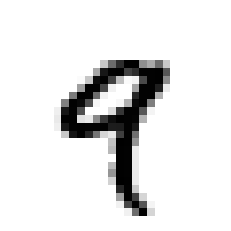

label:  9


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

digit = X_train[4]
label = y_train[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.axis('off')
plt.show()
print('label: ', label)

'''
keras의 MNIST 이미지는 scikit-learn 보단 고화질이다...
'''

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
print(y_test_5)

[False False False ... False  True False]


## 2. 데이터 전처리

In [13]:
# 흑백 이미지 데이터는 픽셀 하나당 0~255의 숫자값을 가지기 때문에 255로 나눠준다
# 이걸 255로 나눠주게 되면, 모든 값들이 0~1 사이로 normalize 된다.

X_train = X_train.reshape((60000, 28*28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28*28))
X_test = X_test.astype('float32') / 255

## 3. 네트워크 정의 + 컴파일

In [14]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(32, input_shape=(28*28,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1, activation='softmax'))

model.compile(loss = 'binary_crossentropy', #'mse'
             optimizer = 'sgd',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,209
Trainable params: 26,209
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


In [31]:
# 이 부분 이해가 잘 안가니까 레이어 별로 속성을 뽑아보자

l1 = model.layers[0]
l2 = model.layers[1]

print(l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params())
print(l2.name, type(l1), l2.output_shape, l2.activation.__name__, l2.count_params())

dense_1 <class 'keras.layers.core.Dense'> (None, 32) relu 25120
dense_2 <class 'keras.layers.core.Dense'> (None, 32) relu 1056


## 4. 모델 학습

In [15]:
hist = model.fit(X_train, y_train_5, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 2s 39us/step - loss: 0.1676 - acc: 0.9404


In [16]:
loss, acc = model.evaluate(X_train, y_train_5, verbose=0)
print(loss)
print(acc)

0.10069070021659136
0.96795


## 5. 분류 결과 분석

### - 혼동 행렬 (confusion matrix)

In [17]:
from tensorflow.keras.utils import to_categorical

y_pred_5 = model.predict(X_test).ravel()
y_pred_5 = y_pred_5 > 0.5
print(y_pred_5)
print(y_test_5)

[False False False ... False False False]
[False False False ... False  True False]


In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_5, y_pred_5) # pred는 value로 전달
print(cm)

[[9056   52]
 [ 254  638]]


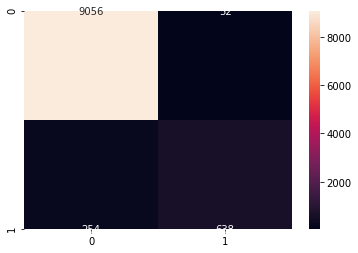

In [23]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')

In [32]:
y_pred_5 = model.predict(X_test)

print(y_pred_5)

[[4.4725835e-03]
 [9.2422158e-02]
 [1.4822483e-02]
 ...
 [1.0689646e-02]
 [4.1145369e-01]
 [2.9626489e-04]]


In [33]:
import numpy as np

# y_pred_5 는 다차원 배열이니까, 1차원배열로 다 펴준다
y_pred_5 = model.predict(X_test).ravel()

print(y_pred_5)
print(y_test_5)

[4.4725835e-03 9.2422158e-02 1.4822483e-02 ... 1.0689646e-02 4.1145369e-01
 2.9626489e-04]
[False False False ... False  True False]


### - Precision-Recall 커브

- Precision Recall Curve 는 .... TP와 PV(predictive value) 사이의 trade-off 관계를 나타내줌
- ROC랑은 다른게, PR Curve는 주로 imbalanced 한 데이터셋의 trade-off 관계를 찍어낼 때 적합함

> **그래서, MNIST 에서 굳이 Precision/Recall Trade-off 관계를 따지는 이유는?**

- 우선 우리가 지금 MNIST 데이터를 분류했던 모델이 SGD 분류모델인데,
- SGD모델이 분류결정을 할 땐, 각각의 instance 에 대해 decision function 기반으로 점수를 계산하고
    - 만약 score 가 임계값(threshold)보다 높으면 positive class,
    - 그렇지 않으면 negative class에 해당함
    
873952556555 의 손글씨 숫자들이 있다고 가정해보자.    
    
- 가운데의 5를 decision threshold 로 두고, 오른쪽을 보면 5라는 숫자가 4개다.
    - 873952 5 6555 
    - 여기서 6은 false positive가 된다.
    - 예측은 5로 했는데 5가 아닌 값이 튀어나온다.
    - 따라서 이 임계값을 사용하면, Accuracy는 80% 가 된다.
        - TP / (FP + TP) = 4 / (1+4)
- 근데 실제 5의 갯수는 6개인데 실제 값의 범위에는 5가 4개밖에 안들어있음
    - 그래서 recall 은 67% 가 된다.
        - TP / (TP + FN) = 4 / (4+2)

임계값을 조금 오른쪽으로 움직이면...
    - Precision은 100%가 됨.
        - TP / (FP + TP) = 3 / (0+3)
    - 근데.. recall 은 50%가 된다 (!)
        - 3 / (3+3)

임계값을 왼쪽으로 움직이면? ->  반대로 된다.

SGD 분류기는 threshold 를 기본 0으로 두고 사용한다.
    - 이전 predict() 함수 사용 결과와 동일하게 True 값을 뱉어낸다.
    - 여기서, threshold 값을 높이면, recall 이 감소하고
        - threshold 값을 무진장 높이면 (막 터무늬 없는값.. 예를들면 30만), 아예 탐색을 못한다.
        
> 그러면 우리가 임계값을 어떻게 결정하는데?

    - 아까 위에 코드에서 confusion matrix 를 통해 T/F 불리안 값이 아닌, 연산 가능한 value 로 pred 를 저장해주었으니,
    - 이걸 scikit-learn 에서 제공하는 만들어둔 PR Curve 함수로 계산이 가능함.
    

[0.10380542 0.10370112 0.10371319 ... 1.         1.         1.        ]
[1.         0.99887892 0.99887892 ... 0.00224215 0.00112108 0.        ]
[3.5029650e-04 3.5086274e-04 3.5271049e-04 ... 9.7592741e-01 9.7627449e-01
 9.7700107e-01]
8549
8549
8548
10000


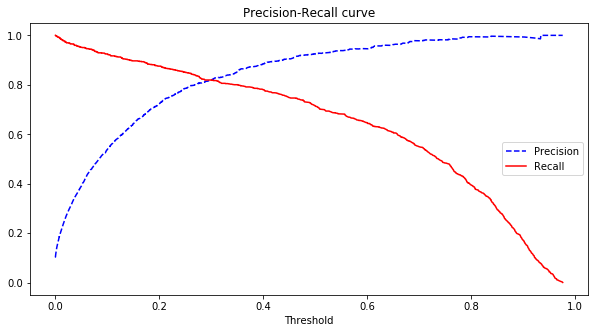

In [25]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_pred_5) # pred 인자는 score(probability) 값으로 전달
print(precisions)
print(recalls)
print(thresholds)
print(len(precisions))
print(len(recalls))
print(len(thresholds))
print(len(y_test_5))

plt.figure(figsize=(10,5))
plt.title('Precision-Recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

### - ROC 커브

- 이거는 위에 PR Curve와 유사하긴 한데, precision을 plotting 하는 대신에, FPR 에 대해 TPR을 plotting 하는것에서 차이점이 있음
    - 뭐가 trade-off 관계냐 이 차이임 그냥

근데 너무 편한게, FPR, TPR 계산을 해야하는데 저 함수 쓰면 계산이 됨 ㅋㅋㅋㅋ

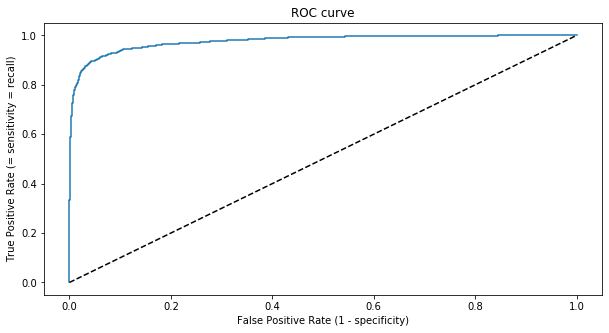

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_5, y_pred_5)

plt.figure(figsize=(10,5))
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (= sensitivity = recall)')
plt.show()

In [27]:
# MNIST 예제에서는 다층 퍼셉트론은 그다지 적합하지 않다
# 그래서 28 * 28 1차원 벡터로 reshape 해서 퍼셉트론을 생성한다.

from sklearn.linear_model import Perceptron

perceptron = Sequential()
perceptron.add(Dense(1, input_shape=(28*28,), activation='sigmoid'))
perceptron.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['acc'])
perceptron.fit(X_train, y_train_5,
              epochs = 1)

Epoch 1/1
60000/60000 [==============================] - 1s 24us/step - loss: 0.1959 - acc: 0.9263


In [28]:
y_perceptron = perceptron.predict(X_test)
print(y_perceptron)

[[0.02809548]
 [0.13481477]
 [0.0508669 ]
 ...
 [0.03361291]
 [0.15542743]
 [0.00223953]]


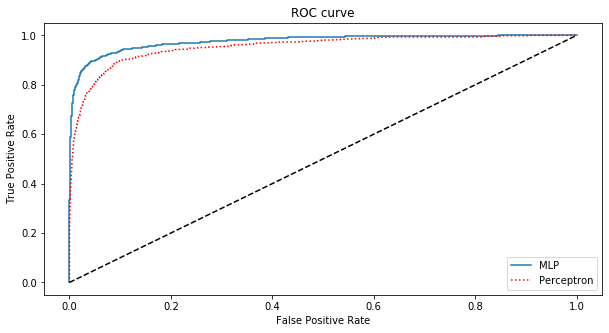

In [29]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_test_5, y_pred_5)
fpr2, tpr2, thresholds2 = roc_curve(y_test_5, y_perceptron)

plt.figure(figsize=(10,5))
plt.title('ROC curve')
plt.plot(fpr1, tpr1, label='MLP')
plt.plot(fpr2, tpr2, 'r:', label='Perceptron')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_test_5, y_pred_5)
auc2 = roc_auc_score(y_test_5, y_perceptron)
print('AUC of MLP :', auc1)
print('AUC of Perceptron :', auc2)

AUC of MLP : 0.9761109092484606
AUC of Perceptron : 0.9538754305582635
